In [16]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import cv2
import statistics
import skimage as ski
from skimage.morphology import square,disk
from scipy import signal
from scipy import stats
from pathlib import Path
import hashlib
import numbers
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import datetime
from datetime import datetime

In [2]:
def check_plunger_states(files, plengths=None):
    """
    Checks is plunger in the line, and which one.....
    """
    if plengths is None:

        plengths = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.3]
        
    results = []

    for i, file_path in enumerate(files):
        
        plunger_state = 0
        plunger_in = None
        is_there_a_plunger = 0
 
        try:

            with h5py.File(file_path, 'r') as f:
                
                for p in range(len(plengths)):
                    try:
                        plunger = list(f['AwakeEventData'][f'AWAKE.XAWAV2_PE_P{p + 1}_ST']['PosSt']['value'])

                    except:
                        pass

                    else:
                        plunger_state = int(plunger[0])

                    try:
                        plunger = list(f['AwakeEventData'][f'AWAKE.XAWAV2_PG_P{p + 1}_ST']['PosSt']['value'])

                    except:
                        pass

                    else:
                        plunger_state = int(plunger[0])
                        

                    if plunger_state == 3 or plunger_state == 4:
                        plunger_in = p + 1
                        is_there_a_plunger = 1

                        break
 

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

            continue
 
        results.append({
            "index": i,
            "file": file_path,
            "is_there_a_plunger": bool(is_there_a_plunger),
            "plunger_in": plunger_in
        })

    return results

In [3]:
def fit_line(x,a,b):
    return a*x + b

In [4]:
def load_all_event_data(date,event_filename,spectro_no,threshold):
    
    with h5py.File('/eos/experiment/awake/event_data/'+date+'/'+ event_filename, 'r') as f:
        root = f['AwakeEventData']

        # Main data
        spectro_path = f'TCC4.SPECTRO{spectro_no}.DigiCam'

        try:
            data = root[spectro_path]['ExtractionImage']['image2D'][:]
            protons = root['TT41.BCTF.412340']['CaptureAcquisition']['totalIntensity'][0]
            
            ## sort BTV54
            screen_of_interest = root['TT41.BTV.412354.DigiCam']['ExtractionImage']['image2D'][400:610,510:720]
            bg_sensor = np.array(screen_of_interest) - 3.78126279
            w_median_filter = ski.filters.median(bg_sensor, footprint=disk(3)) 

            total_count = np.sum(w_median_filter)

            if protons !=0 and total_count > threshold:
                BTV54_position = 1

            else:
                BTV54_position = 0
                
                
            rif = root['Sps2AwakeSynchro']['ProtonDelayNs']['delay'][0]
            plunger_status = check_plunger_states(['/eos/experiment/awake/event_data/'+date+'/'+ event_filename])
            laser_firing = root['EMETER04']['Acq']['value'][0]

            ## sort based on threshold
            if laser_firing > 0.05:
                laser_value = 1

            else:
                laser_value = 0

            # Screens
            screens = {
                'OTR': root['MPP-VACTRANS-OTR']['Acquisition']['end_switch_plus_active'][()],
                'CTR': root['MPP-VACTRANS-CTR']['Acquisition']['end_switch_plus_active'][()],
                'LDBP': root['LBDP2']['Acq']['position'][0],
                'Plunger': plunger_status[0]['plunger_in'],
            }

                
        except(ValueError, KeyError):
            protons=0
            BTV54_position = 0
            data = np.zeros((1216,1936))
            screens = {'OTR': 0,
                'CTR': 0,
                'LDBP': 0,
                'Plunger': 0,}
            rif = 0 
            laser_value = 0 
    
    return data, protons, rif, laser_value, screens

In [5]:
def check_screens(screens):

    active_screens = []
    list_screens = ['OTR','CTR','BTV50','BTV53', 'BTV426', 'BTV442', 'LDBP','Plunger', 'BTV54']

    # Determine which screen is active
    screen_used = None
    for screen in list_screens: 
        val = screens.get(screen,None)

        if screen =='LDBP':
            val = screens['LDBP']
            if val == 0:
                active_screens.append('LDBP')

        elif screen == 'Plunger':
            val = screens['Plunger']

            for j in np.arange(1,11,1):
                if val == j:
                    active_screens.append(f'Plunger{j}')                

        elif isinstance(val, (bool, np.bool_)):
            if val == False:
                active_screens.append(screen)

        elif isinstance(val, numbers.Number):
            if float(val) == 1:
                active_screens.append(screen)


    if not active_screens:
        active_screens = ['None']

    # Create a combined label
    screen_label = '+'.join(active_screens)
    return screen_label

In [10]:
def background_subtraction_nofilter(Date, event, camera_number, threshold, stored_event):
    
    ## load data
    event_files = os.listdir(f'/eos/experiment/awake/event_data/{Date}')
    data, protons, rif, laser, screens = load_all_event_data(Date,event_files[event],spectro_no=camera_number,threshold=1.3e6)
    
    ## remove electronic noise and median filter
    bg_sensor = np.array(data) - 3.78126279
    data_w_median_filter = ski.filters.median(bg_sensor, footprint=disk(4)) 
    
    screen_label = check_screens(screens)
    
    date_format = Date.replace('/','-')
    m_c_data = np.load(f"slope_intercept_data_{date_format}_Spectro_{camera_number}_Upto_Event_{stored_event}_nofilter.npz")
    print(m_c_data)
    slopes = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope"]
    intercepts = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_intercepts"]
    #sigma_mm = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope_errors"]
    #sigma_cc = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_intercept_errors"]
    #sigma_mc = m_c_data[f"RIF_{rif}_Laser_0_Screens_{screen_label}_slope_int_errors"]
    
     
    background = slopes*protons + intercepts
    
    #variance = (protons**2) * sigma_mm + 2 * protons * sigma_mc + sigma_cc
    #pixel_uncertainty = np.sqrt(np.abs(variance))  
    #pixel_uncertainty = np.nan_to_num(pixel_uncertainty, nan=0.0, posinf=0.0, neginf=0.0)
    
    print("Shapes - slopes:", slopes.shape, "intercepts:", intercepts.shape, "data:", data.shape)
    print("Protons:", protons)

    cleaned_image = data_w_median_filter - background
    
    return cleaned_image#, pixel_uncertainty#

# Example 1170

In [13]:
Date = '2024/09/14'
DATA_PATH = f'/eos/experiment/awake/event_data/{Date}'
event_files = os.listdir(DATA_PATH)
len(event_files)
print(event_files[963])

1726318911735000000_Type0_2064_2.h5


In [11]:
background_ex_nofilter_ldbp = background_subtraction_nofilter('2024/09/14',1170, 2, threshold=1.75e6,stored_event=5)

NpzFile 'slope_intercept_data_2024-09-14_Spectro_2_Upto_Event_5_nofilter.npz' with keys: RIF_1121740.937_Laser_0_Screens_LDBP_slope, RIF_1121740.937_Laser_0_Screens_LDBP_intercepts
Shapes - slopes: (1216, 1936) intercepts: (1216, 1936) data: (1216, 1936)
Protons: 28.876957


In [14]:
ex_data_plunger, protons, rif, laser, screens = load_all_event_data('2024/09/14',event_files[1170],spectro_no=2,threshold=1750000)

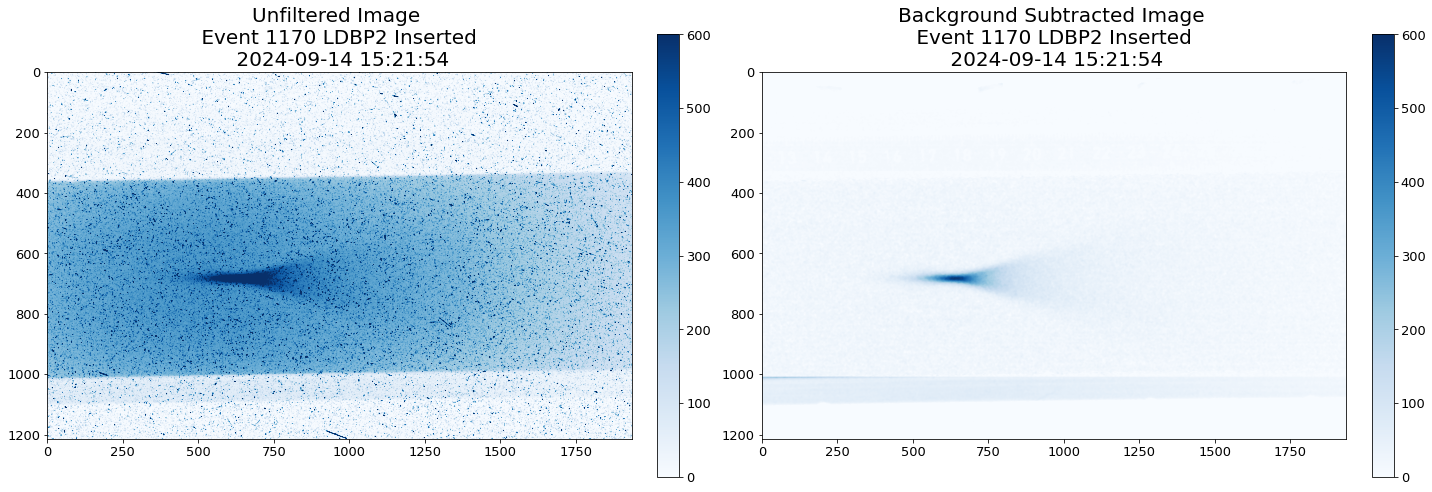

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

selectedEvent = os.path.join(DATA_PATH, event_files[1170])
stamp = int(selectedEvent[44:63])
timestamp = pd.to_datetime(stamp)
formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')

# EVENT 963 
# First subplot
im1 = axes[0].imshow(ex_data_plunger, cmap='Blues', vmin=0,vmax=600)
axes[0].set_title(f'Unfiltered Image \n Event 1170 LDBP2 Inserted \n {formatted_timestamp}', fontsize=20)
cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.035, pad=0.04)
cbar1.ax.tick_params(labelsize=13)


# Second subplot
im2 = axes[1].imshow(background_ex_nofilter_ldbp, cmap='Blues', vmin=0, vmax=600)
axes[1].set_title(f'Background Subtracted Image \n Event 1170 LDBP2 Inserted \n {formatted_timestamp}', fontsize=20)
cbar = fig.colorbar(im2, ax=axes[1], fraction=0.035, pad=0.04)
cbar.ax.tick_params(labelsize=13)


axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[0].tick_params(axis='both', which='major', labelsize=13)


plt.tight_layout()
plt.show()

In [20]:
list_events = [950,963,1193,1215,1063,1170]

In [26]:
for i in np.arange(0,len(list_events),1):
    
    f = h5py.File('/eos/experiment/awake/event_data/'+Date+'/'+ event_files[i], 'r')
    
    rif = f['AwakeEventData']['Sps2AwakeSynchro']['ProtonDelayNs']['delay'][0]    
    
    print(rif - 1121740.837)

0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
1121740.837